<a href="https://colab.research.google.com/github/DanielP53/Labs-SP1/blob/master/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, GRU

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from tensorflow import keras
layers = keras.layers
models = keras.models


#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

##Data


In [34]:
data = pd.read_csv("bbc-text.csv")
data.head()
data['category'].value_counts()

train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

Train size: 1780
Test size: 445


#preparacion

In [35]:
train_cat, test_cat = train_test_split(data['category'], train_size)
train_text, test_text = train_test_split(data['text'], train_size)

max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)
tokenize.fit_on_texts(train_text) # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1780, 1000)
x_test shape: (445, 1000)
y_train shape: (1780, 5)
y_test shape: (445, 5)


#Model

In [0]:
batch_size = 32
epochs = 2
drop_ratio = 0.5

In [0]:
def train(model, epochs=EPOCHS):
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(max_words,)))
  model.add(layers.Activation('relu'))
  # model.add(layers.Dropout(drop_ratio))
  model.add(layers.Dense(num_classes))
  model.add(layers.Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  return model.fit(x_train,y_train, 
                   epochs=epochs,
                  verbose=1,
                   validation_split=0.1
                      )

In [0]:
def plot_accuracy_and_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1.0])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Cross Entropy')
  plt.ylim([0.0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

##Bidirectional LSTM

In [87]:
model = Sequential([
    Embedding(max_words, 32, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(1, activation='softmax')
])

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 32)          32000     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 128)               49664     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 81,793
Trainable params: 81,793
Non-trainable params: 0
_________________________________________________________________


Train on 1602 samples, validate on 178 samples
Epoch 1/5
1602/1602 [==============================] - 1s 395us/sample - loss: 0.4174 - accuracy: 0.8789 - val_loss: 0.1457 - val_accuracy: 0.9607
Epoch 2/5
1602/1602 [==============================] - 0s 194us/sample - loss: 0.0429 - accuracy: 0.9944 - val_loss: 0.1242 - val_accuracy: 0.9607
Epoch 3/5
1602/1602 [==============================] - 0s 182us/sample - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.1247 - val_accuracy: 0.9551
Epoch 4/5
1602/1602 [==============================] - 0s 189us/sample - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.1216 - val_accuracy: 0.9607
Epoch 5/5
1602/1602 [==============================] - 0s 185us/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.1241 - val_accuracy: 0.9607


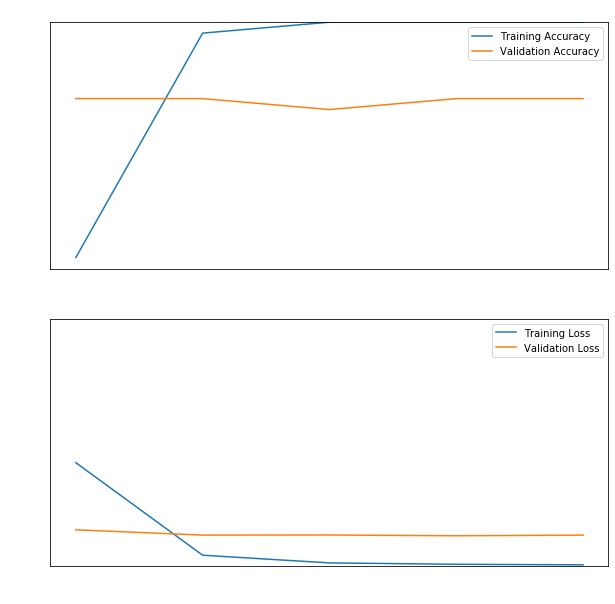

In [88]:
history = train(model)
plot_accuracy_and_loss(history)